# Creating the tidal forcing

In [1]:
from roms_tools import Grid, TidalForcing

We first create our grid object.

In [2]:
grid = Grid(
    nx=100, ny=100, size_x=1800, size_y=2400, center_lon=-10, center_lat=61, rot=-20
)

In [3]:
grid.ds

<xarray.Dataset> Size: 1MB
Dimensions:   (eta_rho: 102, xi_rho: 102, xi_u: 101, eta_v: 101)
Coordinates:
    lat_rho   (eta_rho, xi_rho) float64 83kB 52.04 52.02 52.01 ... 65.87 65.76
    lon_rho   (eta_rho, xi_rho) float64 83kB 331.3 331.5 331.8 ... 18.5 18.77
    lat_u     (eta_rho, xi_u) float64 82kB 52.03 52.02 52.0 ... 65.93 65.81
    lon_u     (eta_rho, xi_u) float64 82kB 331.4 331.7 331.9 ... 18.36 18.63
    lat_v     (eta_v, xi_rho) float64 82kB 52.15 52.13 52.12 ... 65.8 65.68
    lon_v     (eta_v, xi_rho) float64 82kB 331.3 331.5 331.8 ... 18.31 18.58
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables:
    angle     (eta_rho, xi_rho) float64 83kB -0.09192 -0.09192 ... -0.8095
    f         (eta_rho, xi_rho) float64 83kB 0.0001147 0.0001146 ... 0.0001326
    pm        (eta_rho, xi_rho) float64 83kB 4.209e-05 4.208e-05 ... 4.209e-05
    pn        (eta_rho, xi_rho) float64 83kB 5.592e-05 5.592e-05 ... 5.592e-05
    tra_lon   int64 8B -10
    tra_lat   int64 8B 61
    rotate    int64 8B -20
    hraw      (eta_rho, xi_rho) float64 83kB 3.502e+03 3.523e+03 ... -373.9
    mask_rho  (eta_rho, xi_rho) float64 83kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    mask_u    (eta_rho, xi_u) float64 82kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    mask_v    (eta_v, xi_rho) float64 82kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    h         (eta_rho, xi_rho) float64 83kB 3.526e+03 3.526e+03 ... 5.0 5.0
Attributes:
    Type:               ROMS grid produced by roms-tools
    size_x:             1800
    size_y:             2400
    topography_source:  etopo5
    smooth_factor:      8
    hmin:               5.0
    rmax:               0.2

Given our grid, our goal is now to create the necessary tidal forcing fields to run a ROMS simulation.

For the time being, `ROMS-Tools` can only create tidal forcing from the `TPXO` atlas. A copy of this atlas is found here:

In [4]:
path = "/glade/derecho/scratch/bachman/ROMS_tools/DATASETS/tpxo9.v2a.nc"

We now create our tidal forcing for a model reference date of January 1st, 2000.

In [5]:
from datetime import datetime

In [6]:
%%time

tidal_forcing = TidalForcing(
    grid=grid,  # grid object
    filename=path,  # path to the native tidal dataset
    source="tpxo",  # source of the tidal data. Default is "tpxo".
    ntides=10,  # number of constituents to consider. Maximum number is 14. Default is 10.
    model_reference_date=datetime(
        2000, 1, 1
    ),  # reference date for the ROMS simulation. Default is datetime(2000, 1, 1).
    allan_factor=2.0,  # Allan factor
)

CPU times: user 528 ms, sys: 87.2 ms, total: 615 ms
Wall time: 1.37 s


To see the values of the tidal forcing variables we can examine the `xarray.Dataset` object returned by the `.ds` property.

In [7]:
tidal_forcing.ds

<xarray.Dataset> Size: 7MB
Dimensions:  (ntides: 10, eta_rho: 102, xi_rho: 102, xi_u: 101, eta_v: 101)
Coordinates:
    omega    (ntides) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lat_rho  (eta_rho, xi_rho) float64 83kB 52.04 52.02 52.01 ... 65.87 65.76
    lon_rho  (eta_rho, xi_rho) float64 83kB 331.3 331.5 331.8 ... 18.5 18.77
Dimensions without coordinates: ntides, eta_rho, xi_rho, xi_u, eta_v
Data variables:
    ssh_Re   (ntides, eta_rho, xi_rho) float64 832kB dask.array<chunksize=(4, 102, 102), meta=np.ndarray>
    ssh_Im   (ntides, eta_rho, xi_rho) float64 832kB dask.array<chunksize=(4, 102, 102), meta=np.ndarray>
    pot_Re   (ntides, eta_rho, xi_rho) float64 832kB dask.array<chunksize=(4, 102, 102), meta=np.ndarray>
    pot_Im   (ntides, eta_rho, xi_rho) float64 832kB dask.array<chunksize=(4, 102, 102), meta=np.ndarray>
    u_Re     (ntides, eta_rho, xi_u) float64 824kB dask.array<chunksize=(4, 102, 101), meta=np.ndarray>
    u_Im     (ntides, eta_rho, xi_u) float64 824kB dask.array<chunksize=(4, 102, 101), meta=np.ndarray>
    v_Re     (ntides, eta_v, xi_u) float64 816kB dask.array<chunksize=(4, 101, 101), meta=np.ndarray>
    v_Im     (ntides, eta_v, xi_u) float64 816kB dask.array<chunksize=(4, 101, 101), meta=np.ndarray>
Attributes:
    source:                tpxo
    model_reference_date:  2000-01-01 00:00:00
    allan_factor:          2.0

We can also plot any of the tidal forcing fields via the `.plot` method.

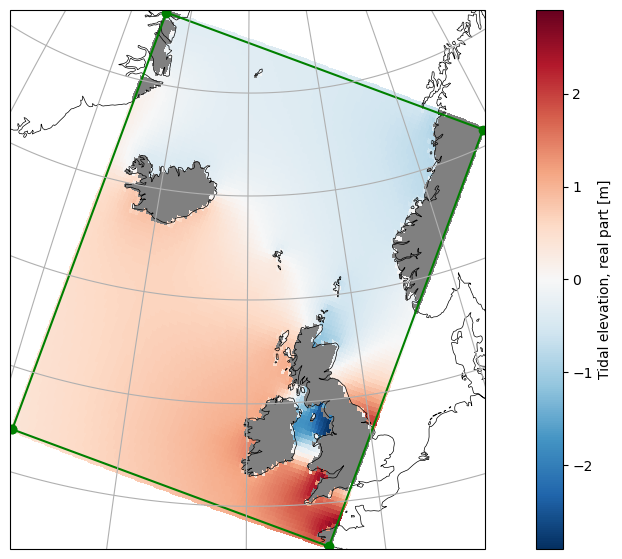

In [8]:
tidal_forcing.plot("ssh_Re", ntides=0)

Finally, we can save our tidal forcing as a netCDF file via the `.save` method.

In [9]:
tidal_forcing.save("forcings/my_tidal_forcing.nc")